# Login

In [1]:
import login
print(login.get_authorization_code())

https://api-t1.fyers.in/api/v3/generate-authcode?client_id=24XH7LLI3A-100&redirect_uri=https%3A%2F%2Fwww.google.com&response_type=code&state=None


In [2]:
import pandas as pd

config_df = pd.read_csv("cred.csv")
config = config_df.iloc[0].to_dict()
refresh_token = config["refresh_token"]

login.get_access_token(refresh_token,login_type="refresh_token")

⚠️ Refresh token failed. Switching to authorization code method.


🔑 Please enter a new authorization code:  eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhcHBfaWQiOiIyNFhIN0xMSTNBIiwidXVpZCI6IjQ2Y2JjMjgzNDk5ZjQ1MmFiYmVhM2E2NTY2M2M3MmI2IiwiaXBBZGRyIjoiIiwibm9uY2UiOiIiLCJzY29wZSI6IiIsImRpc3BsYXlfbmFtZSI6IllTMzU4NzUiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiJhMmYzYzZmYjRkMzY3MmZhN2M0MTI5YmFhZmI5NDE3YjI0YjU5NTkxOTU3ZmYyYmU4NjQ2MTM1OCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImF1ZCI6IltcImQ6MVwiLFwiZDoyXCIsXCJ4OjBcIixcIng6MVwiLFwieDoyXCJdIiwiZXhwIjoxNzQ0MzQ3NDc1LCJpYXQiOjE3NDQzMTc0NzUsImlzcyI6ImFwaS5sb2dpbi5meWVycy5pbiIsIm5iZiI6MTc0NDMxNzQ3NSwic3ViIjoiYXV0aF9jb2RlIn0.g4bL3HPa8hCOH-vShw91nvNijJA9DmdKM3xMnZeK_Y4


✅ Access Token saved successfully in cred.csv
🔄 Refresh Token saved (valid for 15 days)


'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCbi1Dd3d3TG9FRVMySG0yYnluSnF1djRWWmJYTVdfOXhnWGFRSVJ5bS1vcFVLc3l6b1VqeEUyTnIwbWpEWnNZUk9VSXpNYW83c1UtOTUzUXU2UWlTR0tVcUhZUFFwMDRIbVN5aUdreFgzYks0UjNuST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiJhMmYzYzZmYjRkMzY3MmZhN2M0MTI5YmFhZmI5NDE3YjI0YjU5NTkxOTU3ZmYyYmU4NjQ2MTM1OCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiWVMzNTg3NSIsImFwcFR5cGUiOjEwMCwiZXhwIjoxNzQ0NDE3ODAwLCJpYXQiOjE3NDQzMTc0ODgsImlzcyI6ImFwaS5meWVycy5pbiIsIm5iZiI6MTc0NDMxNzQ4OCwic3ViIjoiYWNjZXNzX3Rva2VuIn0.g2xYE6nRGaSoqRBXn4pAiKh3Eg9pbxI6yxosFaN_BfY'

# Data Fetching and Data Analysis

In [14]:
import pandas as pd
import datetime
import time
from fyers_apiv3 import fyersModel

# Load credentials from CSV
config = pd.read_csv("cred.csv").iloc[0].to_dict()
client_id = config["client_id"]
access_token = config["access_token"]

# Initialize FYERS Model
fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

# Define symbol and date range parameters
symbol = "MCX:CRUDEOILM25APRFUT"  # Your chosen symbol
chunk_size = 100  # days per request (FYERS API limit)
total_days = 1000  # Total days to fetch

end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=total_days)

# Store all data
all_data = []

# Fetch data in chunks of 100 days (5 iterations for 500 days)
for _ in range(10):
    next_end_date = start_date + datetime.timedelta(days=chunk_size)
    if next_end_date > end_date:
        next_end_date = end_date

    requirement = {
        "symbol": symbol,
        "resolution": "60",  # 30-minute candles
        "date_format": "1",  # YYYY-MM-DD format
        "range_from": start_date.strftime("%Y-%m-%d"),
        "range_to": next_end_date.strftime("%Y-%m-%d"),
        "cont_flag": "1"
    }

    print(f"Fetching data from {requirement['range_from']} to {requirement['range_to']}...")
    try:
        response = fyers.history(data=requirement)
        if "candles" in response:
            df = pd.DataFrame(response["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            # Convert timestamp from Unix to datetime and add 5 hours 30 minutes for IST conversion
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s") + pd.Timedelta(hours=5, minutes=30)
            all_data.append(df)
        else:
            print("No data found:", response)
    except Exception as e:
        print("Error:", e)

    # Move start_date forward
    start_date = next_end_date
    time.sleep(1)  # To avoid API rate limits

# Combine all chunks into a single DataFrame
if all_data:
    final_df = pd.concat(all_data).sort_values(by="timestamp")
    print("✅ DataFrame is ready for analysis!")
else:
    final_df = pd.DataFrame()
    print("❌ No data retrieved.")

# Save the DataFrame to a CSV file
final_df.to_csv("model_train.csv", index=False)
print("✅ Data saved to model_train.csv")


Fetching data from 2022-07-15 to 2022-10-23...


2025-04-10:20:43:31,357 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2022-10-23 to 2023-01-31...


2025-04-10:20:43:32,753 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2023-01-31 to 2023-05-11...


2025-04-10:20:43:34,140 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2023-05-11 to 2023-08-19...


2025-04-10:20:43:35,533 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2023-08-19 to 2023-11-27...


2025-04-10:20:43:36,938 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2023-11-27 to 2024-03-06...


2025-04-10:20:43:38,658 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2024-03-06 to 2024-06-14...


2025-04-10:20:43:40,55 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2024-06-14 to 2024-09-22...


2025-04-10:20:43:41,442 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2024-09-22 to 2024-12-31...


2025-04-10:20:43:42,826 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


Fetching data from 2024-12-31 to 2025-04-10...


2025-04-10:20:43:44,194 DEBUG    [fyersModel.py:140] {'Status Code': 200, 'API': '/history'}


✅ DataFrame is ready for analysis!
✅ Data saved to model_train.csv


In [15]:
import pandas as pd

basic_data=pd.read_csv("model_train.csv")
basic_data.shape

(7950, 6)

In [16]:
import pandas as pd
import pandas_ta as ta


# Calculate MACD, RSI, Stochastic, BB, SuperTrend, and OBV
basic_data.ta.macd(append=True)
basic_data.ta.rsi(append=True)
basic_data.ta.stoch(append=True)
basic_data.ta.bbands(append=True)
basic_data.ta.supertrend(append=True)
basic_data.ta.obv(append=True)


0         889.00
1        1111.00
2         890.00
3         890.00
4         458.00
          ...   
7945   250855.00
7946   247943.00
7947   243683.00
7948   237509.00
7949   234677.00
Name: OBV, Length: 7950, dtype: float64

               MACD_12_26_9  MACDs_12_26_9  MACDh_12_26_9  RSI_14  \
MACD_12_26_9           1.00           0.96           0.33    0.84   
MACDs_12_26_9          0.96           1.00           0.04    0.70   
MACDh_12_26_9          0.33           0.04           1.00    0.61   
RSI_14                 0.84           0.70           0.61    1.00   
STOCHk_14_3_3          0.64           0.44           0.76    0.85   
STOCHd_14_3_3          0.70           0.51           0.72    0.82   
BBL_5_2.0              0.24           0.26          -0.03    0.16   
BBM_5_2.0              0.23           0.25          -0.03    0.15   
BBU_5_2.0              0.22           0.24          -0.04    0.14   
BBP_5_2.0              0.16           0.05           0.39    0.53   
SUPERT_7_3.0           0.08           0.13          -0.13    0.00   
SUPERTd_7_3.0          0.69           0.62           0.37    0.71   
OBV                    0.06           0.06           0.00    0.05   

               STOCHk_14_3_3  STO

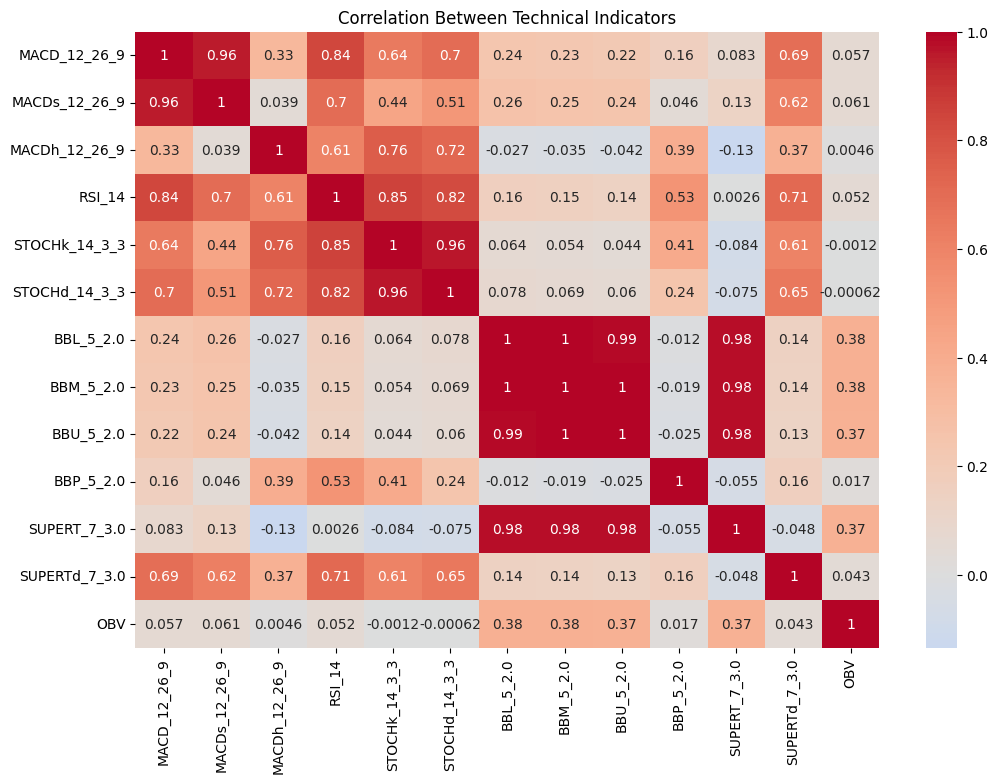

In [18]:
indicators = basic_data[[
    "MACD_12_26_9", "MACDs_12_26_9", "MACDh_12_26_9",
    "RSI_14",
    "STOCHk_14_3_3", "STOCHd_14_3_3",
    "BBL_5_2.0", "BBM_5_2.0", "BBU_5_2.0", "BBP_5_2.0",
    "SUPERT_7_3.0", "SUPERTd_7_3.0",
    "OBV"
]]
corr_matrix = indicators.corr()
print(corr_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Technical Indicators")
plt.show()


In [17]:
basic_data.tail(10)

,timestamp,open,high,low,close,volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,OBV
7940,2025-04-09 18:00:00,4869,4977,4830,4961,6095,-98.98,-15.19,-83.79,38.70,...,4841.54,4937.60,5033.66,3.89,0.62,5128.96,-1,NaN,5128.96,225029.00
7941,2025-04-09 19:00:00,4965,5043,4907,4912,6281,-99.22,-12.34,-86.88,36.05,...,4848.65,4919.40,4990.15,2.88,0.45,5128.96,-1,NaN,5128.96,218748.00
7942,2025-04-09 20:00:00,4914,4966,4876,4958,6006,-94.61,-6.18,-88.43,40.19,...,4848.42,4919.60,4990.78,2.89,0.77,5128.96,-1,NaN,5128.96,224754.00
7943,2025-04-09 21:00:00,4958,4999,4939,4985,2879,-87.76,0.53,-88.29,42.54,...,4853.34,4936.80,5020.26,3.38,0.79,5128.96,-1,NaN,5128.96,227633.00
7944,2025-04-09 22:00:00,4982,5320,4905,5221,15039,-62.57,20.58,-83.15,58.04,...,4788.64,5007.40,5226.16,8.74,0.99,4685.65,1,4685.65,NaN,242672.00
7945,2025-04-09 23:00:00,5226,5378,5207,5325,8183,-33.83,39.46,-73.28,62.80,...,4755.19,5080.20,5405.21,12.80,0.88,4853.34,1,4853.34,NaN,250855.00
7946,2025-04-10 17:00:00,5267,5271,5200,5252,2912,-16.74,45.23,-61.98,57.84,...,4851.36,5148.20,5445.04,11.53,0.67,4853.34,1,4853.34,NaN,247943.00
7947,2025-04-10 18:00:00,5251,5251,5167,5176,4260,-9.23,42.20,-51.43,53.13,...,4963.35,5191.80,5420.25,8.80,0.47,4853.34,1,4853.34,NaN,243683.00
7948,2025-04-10 19:00:00,5175,5183,5086,5172,6174,-3.56,38.29,-41.85,52.89,...,5116.53,5229.20,5341.87,4.31,0.25,4853.34,1,4853.34,NaN,237509.00
7949,2025-04-10 20:00:00,5170,5180,5110,5166,2832,0.45,33.84,-33.39,52.50,...,5094.30,5218.20,5342.10,4.75,0.29,4853.34,1,4853.34,NaN,234677.00


if 2hours later closing price is 1% more : 1
if 2hours later closing price is 1% less: -1
else:0

2hours=4 data point

In [19]:
df = basic_data.copy()  # Don't modify original

# Target creation
df["future_close_2h"] = df["close"].shift(-24)
df["future_return_2h"] = (df["future_close_2h"] - df["close"]) / df["close"]

# Define target using ±0.45% threshold
threshold = 0.03
df["target"] = 0
df.loc[df["future_return_2h"] >= threshold, "target"] = 1
df.loc[df["future_return_2h"] <= -threshold, "target"] = -1

# Drop rows with NaN in future_close_2h
df.dropna(subset=["future_close_2h"], inplace=True)

# Final selected features
selected_features = ["timestamp",
    "open", "high", "low", "close", "volume",
    "MACD_12_26_9", "RSI_14", "STOCHk_14_3_3",
    "BBP_5_2.0", "SUPERTd_7_3.0", "OBV", "target"
]

# Save filtered dataset
df[selected_features].to_csv("current_dataset.csv", index=False)


# Volatility based target

future close -> future return -> take log -> rolling standard deviation (volatility) -> threshold  -> target column


In [89]:
import numpy as np

df = basic_data.copy()

# Step 1: Target creation
df["future_close_2h"] = df["close"].shift(-24)
df["future_return_2h"] = (df["future_close_2h"] - df["close"]) / df["close"]

# Step 2: Calculate rolling % volatility
df["log_return"] = df["close"] / df["close"].shift(1)
df["volatility"] = df["log_return"].rolling(10).std()  # Now it's a small number like 0.004

# Step 3: Dynamic threshold and target
df["threshold"] = df["volatility"] * 1.6
df["target"] = 0
df.loc[df["future_return_2h"] >= df["threshold"], "target"] = 1
df.loc[df["future_return_2h"] <= -df["threshold"], "target"] = -1

# Step 4: Drop invalid rows
df.dropna(subset=["future_close_2h", "threshold"], inplace=True)

# Step 5: Save filtered dataset
selected_features = ["timestamp",
    "open", "high", "low", "close", "volume",
    "MACD_12_26_9", "RSI_14", "STOCHk_14_3_3",
    "BBP_5_2.0", "SUPERTd_7_3.0", "OBV", "target"
]
df[selected_features].to_csv("current_dataset.csv", index=False)


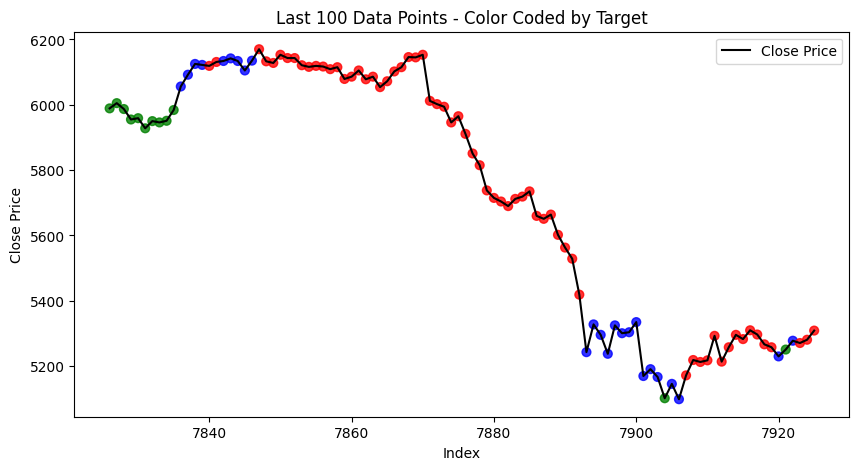

In [90]:
import matplotlib.pyplot as plt

# 1) Extract the last 100 rows from your DataFrame
df_tail = df.tail(100).copy()

# 2) If your target is stored as -1, 0, 1, define a color map:
# target_colors = {-1: 'red', 0: 'blue', 1: 'green'}

# If your target is stored as 0, 1, 2 (remapped), define a color map:
target_colors = {-1: 'red', 0: 'blue', 1: 'green'}

# 3) Create a new column with color values based on your target
df_tail['color'] = df_tail['target'].map(target_colors)

# 4) Plot the 'close' price as a line
plt.figure(figsize=(10, 5))
plt.plot(df_tail.index, df_tail['close'], color='black', label='Close Price')

# 5) Scatter-plot the same points, but colored by target
plt.scatter(df_tail.index, df_tail['close'], c=df_tail['color'], s=40, alpha=0.8)

plt.title("Last 100 Data Points - Color Coded by Target")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [91]:
df["target"].value_counts()

 1    3255
-1    2864
 0    1797
Name: target, dtype: int64

# Also add macro indicators like Treasury yield and FF interest rates

In [92]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=SXQUFRCZTY4PF46D'
r = requests.get(url)
data = r.json()
df1=pd.DataFrame(data["data"])



In [93]:

df1['date'] = pd.to_datetime(df1['date'])

# Clean and convert the 'value' column
df1['value'] = pd.to_numeric(df1['value'].str.replace(r"[^0-9\.-]", "", regex=True), errors='coerce')
df1.rename(columns={'value': 'treasury_yield'}, inplace=True)
df1.dropna(subset=['treasury_yield'], inplace=True)

# --- Prepare main DataFrame df ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date  # extract just the date part

# Convert df1['date'] to just date (not datetime) for merge
df1['date'] = df1['date'].dt.date

# Merge on date
df = pd.merge(df, df1[['date', 'treasury_yield']], on='date', how='left')

# Optional: drop 'date' column if you don't need it anymore
# df.drop(columns=['date'], inplace=True)

In [94]:
df.tail(10)

,timestamp,open,high,low,close,volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,...,SUPERTs_7_3.0,OBV,future_close_2h,future_return_2h,log_return,volatility,threshold,target,date,treasury_yield
7906,2025-04-08 09:00:00,5297,5312,5279,5310,1261,-63.57,36.92,-100.49,48.39,...,5357.18,233787.00,4961.00,-0.07,1.01,0.01,0.01,-1,2025-04-08,4.26
7907,2025-04-08 10:00:00,5310,5316,5291,5297,626,-55.76,35.78,-91.55,47.32,...,5357.18,233161.00,4912.00,-0.07,1.00,0.01,0.01,-1,2025-04-08,4.26
7908,2025-04-08 11:00:00,5297,5301,5267,5267,1199,-51.40,32.11,-83.52,44.86,...,5357.18,231962.00,4958.00,-0.06,0.99,0.01,0.01,-1,2025-04-08,4.26
7909,2025-04-08 12:00:00,5267,5300,5248,5258,1746,-48.12,28.32,-76.44,44.12,...,5357.18,230216.00,4985.00,-0.05,1.00,0.01,0.01,-1,2025-04-08,4.26
7910,2025-04-08 13:00:00,5257,5257,5194,5230,2279,-47.23,23.36,-70.60,41.80,...,5357.18,227937.00,5221.00,-0.00,0.99,0.01,0.01,0,2025-04-08,4.26
7911,2025-04-08 14:00:00,5232,5275,5224,5251,1639,-44.33,21.02,-65.34,44.17,...,5357.18,229576.00,5325.00,0.01,1.00,0.01,0.01,1,2025-04-08,4.26
7912,2025-04-08 15:00:00,5253,5290,5242,5278,1442,-39.39,20.76,-60.15,47.15,...,5357.18,231018.00,5252.00,-0.00,1.01,0.01,0.01,0,2025-04-08,4.26
7913,2025-04-08 16:00:00,5278,5280,5245,5271,1583,-35.63,19.62,-55.25,46.46,...,5357.18,229435.00,5176.00,-0.02,1.00,0.00,0.01,-1,2025-04-08,4.26
7914,2025-04-08 17:00:00,5270,5303,5255,5281,2020,-31.48,19.01,-50.49,47.64,...,5357.18,231455.00,5172.00,-0.02,1.00,0.00,0.01,-1,2025-04-08,4.26
7915,2025-04-08 18:00:00,5281,5330,5275,5309,2636,-25.64,19.89,-45.52,50.90,...,5357.18,234091.00,5166.00,-0.03,1.01,0.00,0.01,-1,2025-04-08,4.26


In [95]:
# Step 5: Save filtered dataset
selected_features = ["timestamp",
    "open", "high", "low", "close", "volume",
    "MACD_12_26_9", "RSI_14", "STOCHk_14_3_3",
    "BBP_5_2.0", "SUPERTd_7_3.0", "OBV", "target","treasury_yield"
]
df[selected_features].to_csv("current_dataset.csv", index=False)

# Model Training

# Model testing

In [3]:
import history
df = history.fetch_historical_data("MCX:CRUDEOILM25APRFUT", "60", ATR=12, mult=2)

df.ta.macd(append=True)
df.ta.rsi(append=True)
df.ta.stoch(append=True)
df.ta.bbands(append=True)
df.ta.supertrend(append=True)
df.ta.obv(append=True)



0      1261.0
1       635.0
2      -564.0
3     -2310.0
4     -4589.0
5     -2950.0
6     -1508.0
7     -3091.0
8     -1071.0
9      1565.0
10     5368.0
11     2182.0
12     6495.0
13      929.0
14     2987.0
15     -951.0
16      342.0
17     2925.0
18     4762.0
19     2900.0
20     4518.0
21      932.0
22    -6376.0
23   -13592.0
24    -7497.0
25   -13778.0
26    -7772.0
27    -4893.0
28    10146.0
29    18329.0
30    15417.0
31    11157.0
32     4983.0
33     1530.0
34    -3475.0
35     -490.0
36     1216.0
37     4128.0
38     -132.0
39    -6306.0
40    -9759.0
41   -14764.0
42   -11779.0
43   -10073.0
Name: OBV, dtype: float64

In [5]:
df.tail()

,timestamp,open,high,low,close,volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,OBV
39,2025-04-10 19:00:00,5175,5183,5086,5172,6174,0.870324,25.351926,-24.481602,52.046044,...,5113.591554,5187.0,5260.408446,2.830478,0.397832,4932.441159,1,4932.441159,NaN,-6306.0
40,2025-04-10 20:00:00,5170,5180,5110,5170,3453,1.527783,20.807508,-19.279725,51.886960,...,5131.215586,5192.8,5254.384414,2.371915,0.314888,4932.441159,1,4932.441159,NaN,-9759.0
41,2025-04-10 21:00:00,5169,5215,5106,5120,5005,-1.963129,13.853277,-15.816406,47.941691,...,5093.411585,5178.0,5262.588415,3.267223,0.157163,4932.441159,1,4932.441159,NaN,-14764.0
42,2025-04-10 22:00:00,5120,5189,5119,5141,2985,-3.000588,10.252654,-13.253242,49.672533,...,5112.231204,5155.8,5199.368796,1.690089,0.330154,4932.441159,1,4932.441159,NaN,-11779.0
43,2025-04-10 23:00:00,5140,5201,5140,5194,1706,0.448703,10.961556,-10.512853,53.843542,...,5107.560247,5159.4,5211.239753,2.009526,0.833721,4932.441159,1,4932.441159,NaN,-10073.0


In [6]:
import pandas as pd
import pickle
import pandas_ta as ta
import requests

with open("model.pkl", "rb") as f:
    azure_model = pickle.load(f)
    


# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey=SXQUFRCZTY4PF46D'
r = requests.get(url)
data = r.json()
df1=pd.DataFrame(data["data"])


########################
df1['date'] = pd.to_datetime(df1['date'])

# Clean and convert the 'value' column
df1['value'] = pd.to_numeric(df1['value'].str.replace(r"[^0-9\.-]", "", regex=True), errors='coerce')
df1.rename(columns={'value': 'treasury_yield'}, inplace=True)
df1.dropna(subset=['treasury_yield'], inplace=True)

# --- Prepare main DataFrame df ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date  # extract just the date part

# Convert df1['date'] to just date (not datetime) for merge
df1['date'] = df1['date'].dt.date

# Merge on date
df = pd.merge(df, df1[['date', 'treasury_yield']], on='date', how='left')

##########################
features = ["timestamp","open", "high", "low", "close", "volume",
                             "MACD_12_26_9", "RSI_14", "STOCHk_14_3_3",
                             "BBP_5_2.0", "SUPERTd_7_3.0", "OBV", "treasury_yield"
                             ]

predictions = azure_model.predict(df[features])
df["prediction"] = predictions
print(df[["timestamp", "prediction"]])

             timestamp  prediction
0  2025-04-08 09:00:00          -1
1  2025-04-08 10:00:00          -1
2  2025-04-08 11:00:00          -1
3  2025-04-08 12:00:00          -1
4  2025-04-08 13:00:00           0
5  2025-04-08 14:00:00           1
6  2025-04-08 15:00:00          -1
7  2025-04-08 16:00:00          -1
8  2025-04-08 17:00:00          -1
9  2025-04-08 18:00:00          -1
10 2025-04-08 19:00:00          -1
11 2025-04-08 20:00:00          -1
12 2025-04-08 21:00:00          -1
13 2025-04-08 22:00:00          -1
14 2025-04-08 23:00:00          -1
15 2025-04-09 09:00:00           0
16 2025-04-09 10:00:00           0
17 2025-04-09 11:00:00           0
18 2025-04-09 12:00:00           0
19 2025-04-09 13:00:00           0
20 2025-04-09 14:00:00           0
21 2025-04-09 15:00:00           0
22 2025-04-09 16:00:00           0
23 2025-04-09 17:00:00           0
24 2025-04-09 18:00:00          -1
25 2025-04-09 19:00:00           0
26 2025-04-09 20:00:00          -1
27 2025-04-09 21:00:

In [7]:
df.tail()

,timestamp,open,high,low,close,volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,...,BBB_5_2.0,BBP_5_2.0,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0,OBV,date,treasury_yield,prediction
39,2025-04-10 19:00:00,5175,5183,5086,5172,6174,0.87,25.35,-24.48,52.05,...,2.83,0.40,4932.44,1,4932.44,NaN,-6306.00,2025-04-10,NaN,-1
40,2025-04-10 20:00:00,5170,5180,5110,5170,3453,1.53,20.81,-19.28,51.89,...,2.37,0.31,4932.44,1,4932.44,NaN,-9759.00,2025-04-10,NaN,-1
41,2025-04-10 21:00:00,5169,5215,5106,5120,5005,-1.96,13.85,-15.82,47.94,...,3.27,0.16,4932.44,1,4932.44,NaN,-14764.00,2025-04-10,NaN,-1
42,2025-04-10 22:00:00,5120,5189,5119,5141,2985,-3.00,10.25,-13.25,49.67,...,1.69,0.33,4932.44,1,4932.44,NaN,-11779.00,2025-04-10,NaN,-1
43,2025-04-10 23:00:00,5140,5201,5140,5194,1706,0.45,10.96,-10.51,53.84,...,2.01,0.83,4932.44,1,4932.44,NaN,-10073.00,2025-04-10,NaN,-1


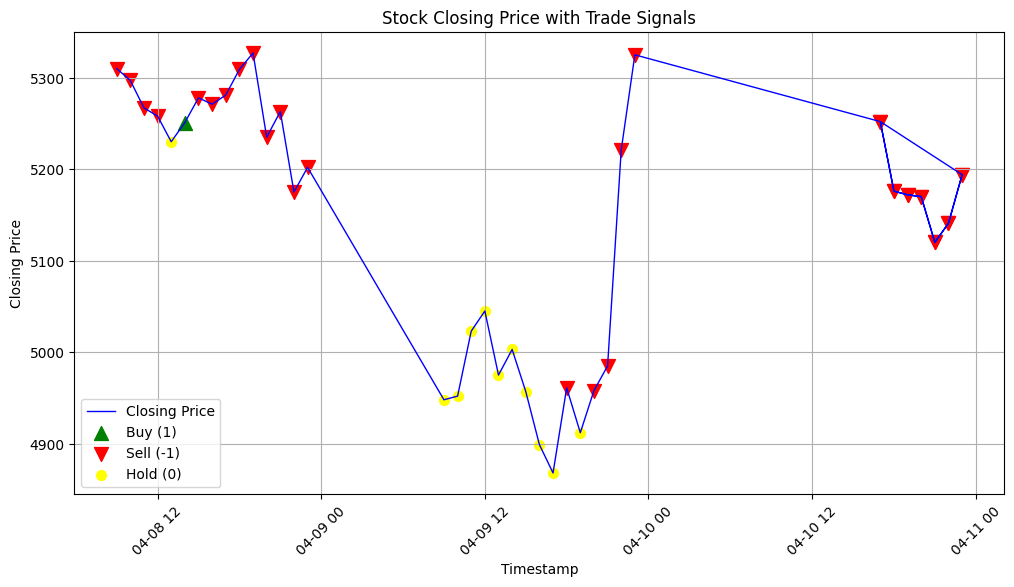

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

df_5m=df.copy()

# Plot closing price
plt.plot(df_5m["timestamp"], df_5m["close"], label="Closing Price", color="blue", linewidth=1)

# Plot buy signals (prediction == 1)
plt.scatter(df_5m[df_5m["prediction"] == 1]["timestamp"], df_5m[df_5m["prediction"] == 1]["close"], 
            marker="^", color="green", s=100, label="Buy (1)")

# Plot sell signals (prediction == -1)
plt.scatter(df_5m[df_5m["prediction"] == -1]["timestamp"], df_5m[df_5m["prediction"] == -1]["close"], 
            marker="v", color="red", s=100, label="Sell (-1)")

# Plot hold signals (prediction == 0)
plt.scatter(df_5m[df_5m["prediction"] == 0]["timestamp"], df_5m[df_5m["prediction"] == 0]["close"], 
            marker="o", color="yellow", s=50, label="Hold (0)")

# Formatting
plt.xlabel("Timestamp")
plt.ylabel("Closing Price")
plt.title("Stock Closing Price with Trade Signals")
plt.legend()
plt.xticks(rotation=45)  # Rotate timestamps for better visibility
plt.grid()

plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score

# Load the dataset
df = pd.read_csv("current_dataset.csv")

# Drop timestamp and separate target
df = df.drop(columns=["timestamp"])
X = df.drop(columns=["target"])
y = df["target"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: impute and scale numerical features
numerical_features = X.columns
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features)
])

# Define the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Define hyperparameter search space
param_dist = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False]
}

# Auto-tuning using RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="roc_auc_ovr_weighted",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Train the model
search.fit(X_train, y_train)

# Predict and evaluate
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
report = classification_report(y_test, y_pred)

# Output
print("Best Hyperparameters:", search.best_params_)
print("Weighted AUC Score:", auc)
print("\nClassification Report:\n", report)
